In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def readtxt(fname):
    f = open(fname, 'r')
    lines = f.readlines()
    content = []
    for line in lines:
        line = line.strip().split()  # 줄 끝의 줄 바꿈 문자를 제거한다.
        if len(line)==0:
            continue
        content.append(np.array(line,dtype=float))
    f.close()
    return np.array(content)

In [3]:
mat = readtxt("mag_array_inliers.txt")
# mat = readtxt("mag_array_outliers.txt")
matk=[]
for i in range(6):
    matk.append(mat[:,i*3:(i+1)*3])

# $\bf{r_j}$ is a vector function of $K,b, \space and \space {x}_j$
## $\bf{r_j} = (K*\hat{x}_j + b) - m_j$

Inlier m_j


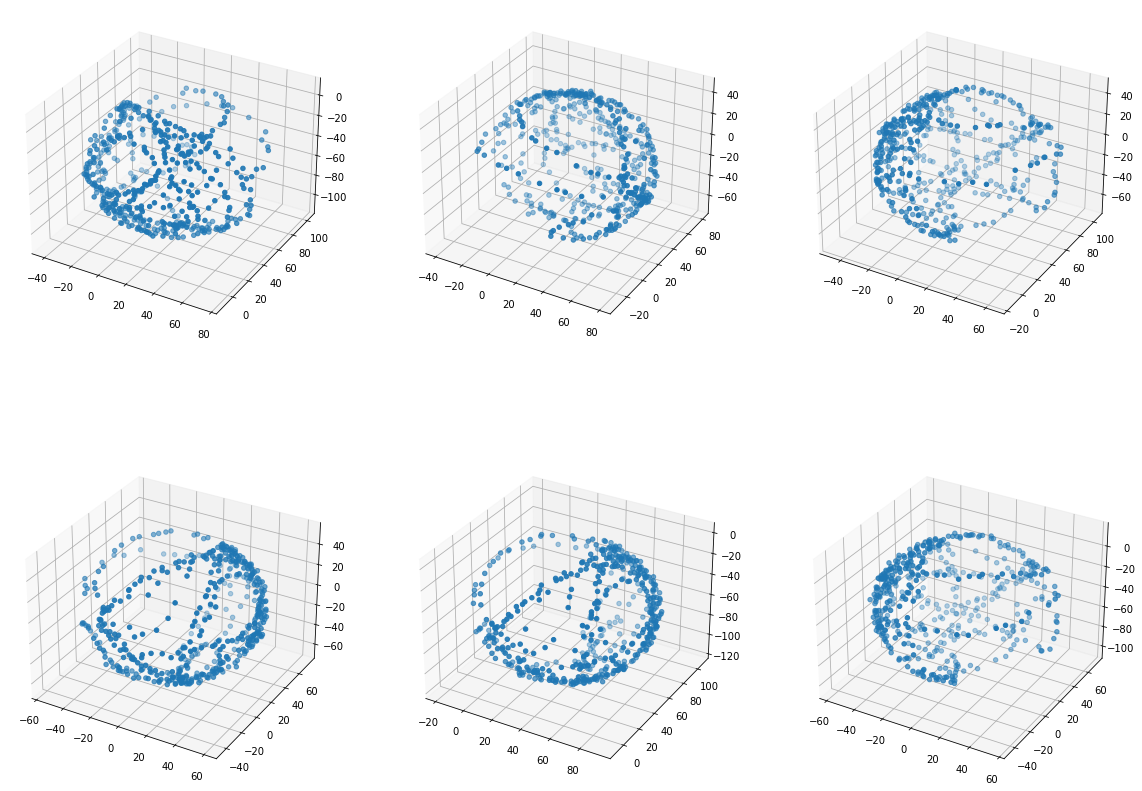

In [4]:
print("Inlier m_j")
fig = plt.figure(figsize=(20,15))
ax=[]
for i in range(6):
    ax.append(fig.add_subplot(int(f'23{i+1}'),projection='3d'))
    ax[i].scatter(matk[i][:,0],matk[i][:,1],matk[i][:,2])
plt.show()

In [5]:
def vec_normalize(x,n): # vector to vector (n*3,1) to (n*3,1)
    x_mat = x.reshape(n,3)
    x_hat = x_mat / (np.linalg.norm(x_mat,axis=1,keepdims=True)+1e-7)
    return x_hat.reshape(-1,1)

def mat_to_diag(K,n):
    K_diag = np.zeros((n*3,n*3))
    for i in range(n):
        K_diag[i*3:(i+1)*3,i*3:(i+1)*3] = K
    return K_diag

def param_to_kbx(p,n):
    K = p[:9].reshape(3,3).T
    b = p[9:12]
    x_vec = p[12:]
    return K, b, x_vec

In [19]:
# Set parameters
def set_param(matk,k):
    n = matk[k].shape[0]
    K = np.eye(3)
    vec_K = K.T.reshape(-1,1)

    b = np.ones((3,1))

    # Initialization

    # X = np.zeros((n*3,1))
    # for i in range(n):
    #     x_j = np.mean(matk[k],axis=0) + 100*np.random.rand(3)*(2*np.random.randint(2)-1)
    #     x_hat_j = x_j/np.linalg.norm(x_j)
    #     X[i*3:(i+1)*3] = x_hat_j.reshape(-1,1)

    X = matk[k].copy()#+np.random.randn(n,3)*(2*np.random.randint(2)-1) # (489*3,1)
    X = X.reshape(n*3,1)
    
    # X = np.random.randn(n,3)
    # X = X.reshape(n*3,1)

    return vec_K,b,X

In [7]:
def compute_resi(p,m,n):
    # change m (489,3) to (489*3,1)
    m_vec = m.reshape(-1,1)

    # print("length of m",n)
    K,b,x_vec = param_to_kbx(p,n)

    x_hat = vec_normalize(x_vec,n)
    K_diag = mat_to_diag(K,n)
    r = K_diag@x_hat+np.tile(b,[n,1])-m_vec

    return r

def compute_jacob(p,m,n):
    K,b,x = param_to_kbx(p,n)
    x_hat = vec_normalize(x,n).reshape(n,3)
    x_mat = x.reshape(n,3)
    # print(np.equal(p[12:],x_vec).all())

    J_k = np.empty((n*3,3*3))
    for i in range(n):
        x1,x2,x3 = x_hat[i]
        J_k[i*3:(i+1)*3,:3]= np.diag(np.repeat(x1,3))
        J_k[i*3:(i+1)*3,3:6]= np.diag(np.repeat(x2,3))
        J_k[i*3:(i+1)*3,6:]= np.diag(np.repeat(x3,3))
    
    J_b = np.tile(np.eye(3),[n,1])
    J_X = np.zeros((n*3,n*3))
    for i in range(n):
        norm_x = np.linalg.norm(x_mat[i])
        x_i = x_mat[i].reshape(3,1)
        J_xi = K@(np.eye(3)/norm_x - x_i@x_i.T/(norm_x**3))
        J_X[3*i:3*(i+1),3*i:3*(i+1)] = J_xi

    return np.concatenate((J_k, J_b, J_X),axis=1)

In [8]:
def compute_model_q(grad,dterm,r,r_new,dp):
    f_del = r_new.T@r_new - r.T@r
    q_del = grad.T@dp+1/2*dp.T@dterm@dp
    print("quality",f_del.item()/q_del.item())
    return f_del.item()/q_del.item()

In [12]:
def LM_iter(p,m,not_converged,damping,eta,tol_fac,cost):
    n=m.shape[0]
    J = compute_jacob(p,m,n) # Jacobian
    r = compute_resi(p,m,n) # vec
    # print("J",J.shape)
    # print("r",r.shape)
    grad = J.T@r
    hess = J.T@J
    # print("grad",grad.shape)
    # print("hess",hess.shape)
    damping_term = hess+damping*np.eye(hess.shape[0])
    dp = -np.linalg.inv(damping_term)@grad

    # K upper triangle
    dp[1]=0
    dp[2]=0
    dp[5]=0
    
    # print("dp",dp.shape)

    p_new = p+dp
    r_new = compute_resi(p_new,m,n)
    rho = compute_model_q(grad,damping_term,r,r_new,dp)

    # Update criterion
    if rho > eta:
        print("update")
        p = p_new.copy()
        new_cost = (np.sqrt(r_new.T@r_new)/n).item()
        prev_cost = (np.sqrt(r.T@r)/n).item()
        func_toler = np.abs(new_cost - prev_cost)
        not_converged = not(func_toler < tol_fac)
        cost.append(new_cost)
        print("func toler",func_toler)
        print("damping",damping)
        
    # Truth region size criteria
    if rho < 0.25:
        damping = min(4*damping,1e+14)
    elif rho > 0.75:
        damping = max(damping/2,1e-14)

    return p, damping, not_converged

In [34]:
def LM(matk,k):
    vec_K, b, X = set_param(matk,k)

    m = matk[k].copy() #(489,3)
    n = m.shape[0]
    p0 = np.concatenate((vec_K,b,X),axis=0) # ((9,1),(3,1),(489*3,1))
    # print("p0",p0.shape)
    p = p0.copy()

    damping = 0.1
    tol_fac = 1e-5
    eta = 0
    not_converged = True
    cost=[]
    
    c=0
    while not_converged:
        p,damping,not_converged = LM_iter(p, m, not_converged, damping, eta, tol_fac, cost)
        if c>1000:
            print("break")
            break
        c+=1
    
    K, b, x_vec = param_to_kbx(p, n)
    x_hat = vec_normalize(x_vec,n)
    K_diag = mat_to_diag(K,n)
    # est = K_diag@x_hat+np.tile(b,[n,1])

    return x_hat.reshape(n,3), p, cost # p 나중에 없애도 될듯

In [35]:
print("Optimized inliers")

params=[]
ests = []
costs = []
for i in range(6):
    est,p,cost = LM(matk,i)
    params.append(p)
    ests.append(est)
    costs.append(cost)

Optimized inliers
quality 1.958315319355813
update
func toler 1.2292575568751234
damping 0.1
quality 2.223145737023999
update
func toler 0.6121979360188088
damping 0.05
quality 2.54220898108232
update
func toler 1.4226641057674314
damping 0.025
quality 3.5052167985544562
update
func toler 6.897720897662008
damping 0.0125
quality 1.7760110773524669
update
func toler 7.104403684850517
damping 0.00625
quality 4.67262075373801
update
func toler 11.185199074751306
damping 0.003125
quality 1.956980668771999
update
func toler 7.493244197196807
damping 0.0015625
quality 6.0898476666068415
update
func toler 16.497726543685715
damping 0.00078125
quality -2.1338904135767507
quality 1.354297988784255
update
func toler 4.612762358459122
damping 0.0015625
quality 1.8770726178095665
update
func toler 4.5050607268377
damping 0.00078125
quality 2.01199863632509
update
func toler 6.829935322339162
damping 0.000390625
quality -8.859317887866087
quality 1.9840604727831312
update
func toler 5.2016957479193

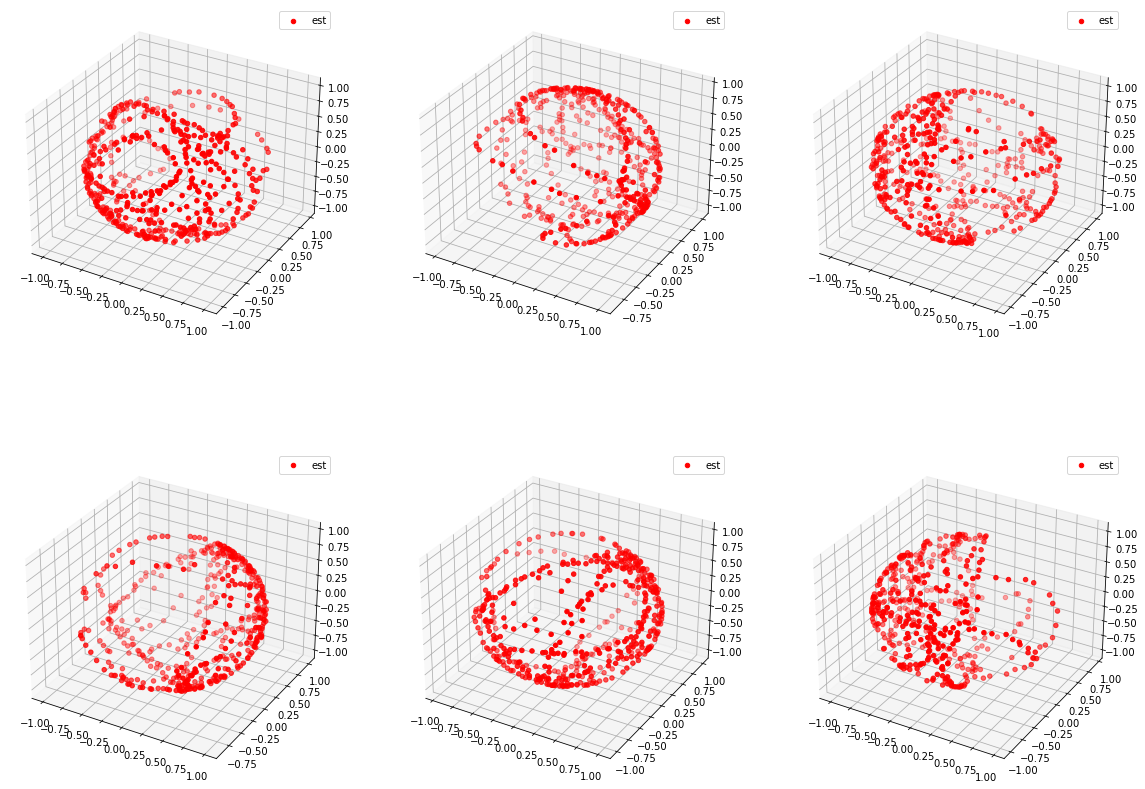

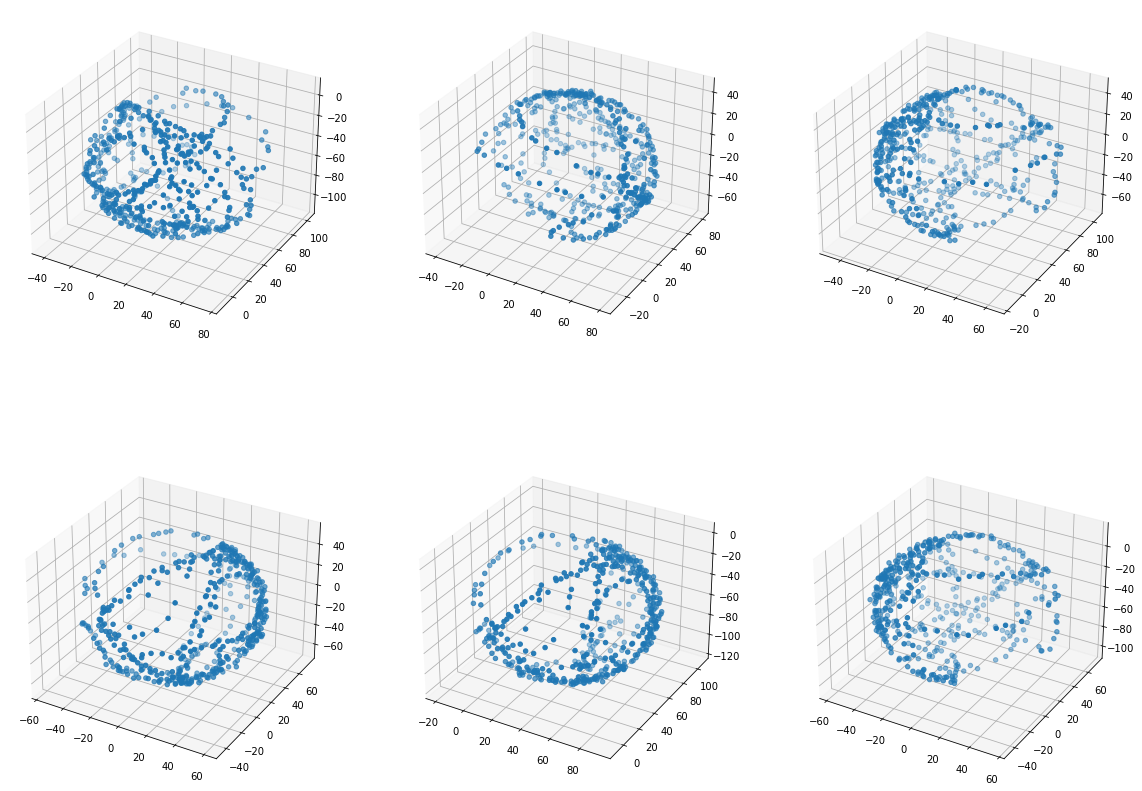

In [36]:
fig = plt.figure(figsize=(20,15))
ax=[]
for i in range(6):
    ax.append(fig.add_subplot(int(f'23{i+1}'),projection='3d'))
    ax[i].scatter(ests[i][:,0],ests[i][:,1],ests[i][:,2],c='r',label='est')
    ax[i].legend()
    
fig2 = plt.figure(figsize=(20,15))
ax2=[]
for i in range(6):
    ax2.append(fig2.add_subplot(int(f'23{i+1}'),projection='3d'))
    ax2[i].scatter(matk[i][:,0],matk[i][:,1],matk[i][:,2],label='m_j')
    ax[i].legend()

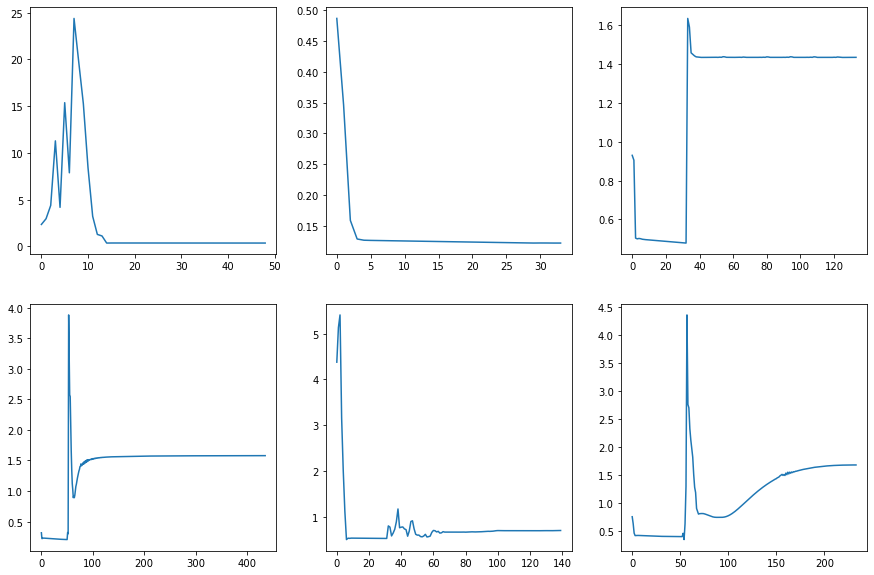

In [33]:
fig, axes = plt.subplots(2,3,figsize=(15,10))
for i in range(6):
    axes[i//3,i%3].plot(range(len(costs[i])),costs[i])

# Robust

In [24]:
mat_out = readtxt("mag_array_outliers.txt")
mat_outk=[]
for i in range(6):
    mat_outk.append(mat_out[:,i*3:(i+1)*3])

Optimized inliers


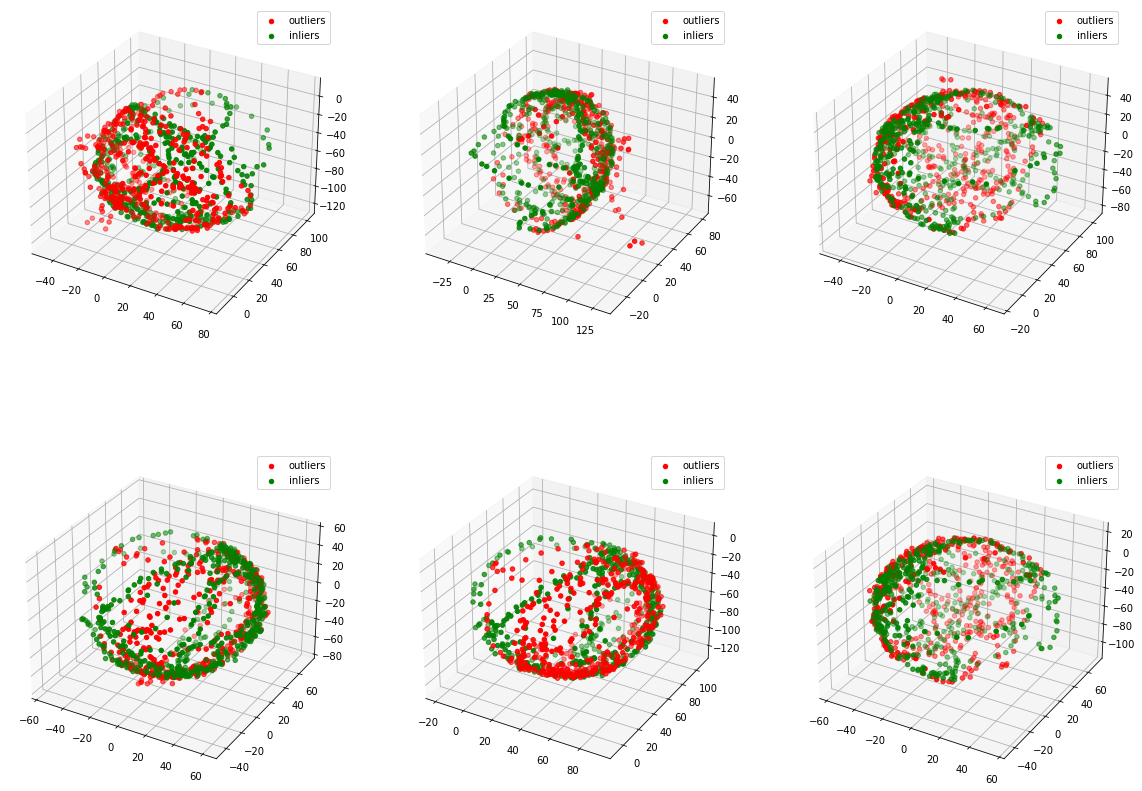

In [25]:
print("Optimized inliers")
fig = plt.figure(figsize=(20,15))
ax=[]
for i in range(6):
    ax.append(fig.add_subplot(int(f'23{i+1}'),projection='3d'))
    ax[i].scatter(mat_outk[i][:,0],mat_outk[i][:,1],mat_outk[i][:,2],c='r',label = "outliers")
    ax[i].scatter(matk[i][:,0],matk[i][:,1],matk[i][:,2],c='g',label = "inliers")
    ax[i].legend()

In [ ]:
def ransac_iter(p,m,not_converged,damping,eta,tol_fac,cost):    
    for k in range(1000):
        n=m.shape[0]
        J = compute_jacob(p,m,n) # Jacobian
        r = compute_resi(p,m,n) # vec
        
        sample_ind = np.random.permutation(n)[:200]
        J = J[sample_ind]
        r = r[sample_ind]
        print("J",J.shape)
        print("r",r.shape)
        
        grad = J.T@r
        hess = J.T@J
        print("grad",grad.shape)
        print("hess",hess.shape)
        damping_term = hess+damping*np.eye(hess.shape[0])
        dp = -np.linalg.inv(damping_term)@grad

        # K upper triangle
        dp[1]=0
        dp[2]=0
        dp[5]=0
        
        # print("dp",dp.shape)

        p_new = p+dp
        r_new = compute_resi(p_new,m,n)
    rho = compute_model_q(grad,damping_term,r,r_new,dp)

    # Update criterion
    if rho > eta:
        print("update")
        p = p_new.copy()
        new_cost = (np.sqrt(r_new.T@r_new)/n).item()
        prev_cost = (np.sqrt(r.T@r)/n).item()
        func_toler = np.abs(new_cost - prev_cost)
        not_converged = not(func_toler < tol_fac)
        cost.append(new_cost)
        print("func toler",func_toler)
        print("damping",damping)
        
    # Truth region size criteria
    if rho < 0.25:
        damping = min(4*damping,1e+14)
    elif rho > 0.75:
        damping = max(damping/2,1e-14)

    return p, damping, not_converged

In [ ]:
# ransac
def RANSAC(matk,k):
    vec_K, b, X = set_param(matk,k)
    # print(vec_K.shape)
    # print(b.shape)
    # print(X.shape)

    m = matk[k] #(489,3)
    n = m.shape[0]
    p0 = np.concatenate((vec_K,b,X),axis=0) # ((9,1),(3,1),(489*3,1))
    # print("p0",p0.shape)
    p = p0.copy()

    damping = 0.1
    tol_fac = 1e-4
    eta = 0
    not_converged = True
    cost=[]
    
    c=0
    while not_converged:
        n = 100
        p,damping,not_converged = ransac_iter(p, m, not_converged, damping, eta, tol_fac, cost)
        if c>100:
            print("break")
            break
        c+=1
    
    K, b, x_vec = param_to_kbx(p, n)
    x_hat = vec_normalize(x_vec,n)
    K_diag = mat_to_diag(K,n)
    est = K_diag@x_hat+np.tile(b,[n,1])

    return est.reshape(n,3), p, cost # p 나중에 없애도 될듯

In [ ]:
print("Optimized inliers")
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(121,projection='3d')
i=0
est,p,cost = RANSAC(matk,i)
ax.scatter(est[:,0],est[:,1],est[:,2],c='r')
ax.scatter(matk[i][:,0],matk[i][:,1],matk[i][:,2])
ax.legend()

ax2 = fig.add_subplot(122)
ax2.plot(range(len(cost)),cost)


In [ ]:
def IRLS_iter(p,m,not_converged,damping,eta,tol_fac,cost):
    n=m.shape[0]
    J = compute_jacob(p,m) # Jacobian
    r = compute_resi(p,m) # vec
    
    # print("J",J.shape)
    # print("r",r.shape)
    grad = J.T@r
    hess = J.T@J
    # print("grad",grad.shape)
    # print("hess",hess.shape)
    damping_term = hess+damping*np.eye(hess.shape[0])
    dp = -np.linalg.inv(damping_term)@grad

    # K upper triangle
    dp[1]=0
    dp[2]=0
    dp[5]=0
    
    p_new = p+dp
    r_new = compute_resi(p_new,m)
    rho = compute_model_q(grad,damping_term,r,r_new,dp)

    # Update criterion
    if rho > eta:
        print("update")
        p_prev = p.copy()
        p = p_new.copy()
        new_cost = (np.sqrt(r_new.T@r_new)/n).item()
        prev_cost = (np.sqrt(r.T@r)/n).item()
        func_toler = np.abs(new_cost - prev_cost)
        not_converged = not(func_toler < tol_fac)
        cost.append(new_cost)
        print("func toler",func_toler)
        print("damping",damping)
        
    # Truth region size criteria
    if rho < 0.25:
        damping = min(4*damping, 1e+14)
    elif rho > 0.75:
        damping = max(damping/2, 1e-14)

    return p, damping, not_converged

In [ ]:
def IRLS_correction(matk,k):
    vec_K, b, X = set_param(matk,k)
    # print(vec_K.shape)
    # print(b.shape)
    # print(X.shape)

    m = matk[k] #(489,3)
    n = m.shape[0]
    p0 = np.concatenate((vec_K,b,X),axis=0) # ((9,1),(3,1),(489*3,1))
    # print("p0",p0.shape)
    p = p0.copy()

    damping = 0.1
    tol_fac = 1e-4
    eta = 0
    not_converged = True
    cost=[]
    
    c=0
    while not_converged:
        p,damping,not_converged = IRLS_iter(p, m, not_converged, damping, eta, tol_fac, cost)
        if c>100:
            print("break")
            break
        c+=1
    
    K, b, x_vec = param_to_kbx(p, n)
    x_hat = vec_normalize(x_vec,n)
    K_diag = mat_to_diag(K,n)
    est = K_diag@x_hat+np.tile(b,[n,1])

    return est.reshape(n,3), p, cost # p 나중에 없애도 될듯

In [ ]:
print("Optimized inliers")
fig = plt.figure(figsize=(20,15))
ax=[]
params=[]
ests = []
costs = []
for i in range(6):
    ax.append(fig.add_subplot(int(f'23{i+1}'),projection='3d'))
    est_out,p,cost = LM(mat_outk,i)
    ax[i].scatter(est_out[:,0],est_out[:,1],est_out[:,2],c='r')
    ax[i].scatter(mat_outk[i][:,0],mat_outk[i][:,1],mat_outk[i][:,2])
    params.append(p)
    ests.append(est_out)
    costs.append(cost)